<a href="https://colab.research.google.com/github/marinacer/IA048/blob/main/glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   aplicar scaling para todos exceto random forest 

2.   explicar o método minmaxscaler que é um scaler robusto a outliners
3.   algoritmos variados: svm é linear, knn não paramemtrico
random forest não linear, ensemble
4. oversampling para compensar o desbalanceamento das classes
5. matriz de confusão para os melhores hiperparamentos de cada método


In [28]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
# open the csv file to dataframe
df = pd.read_csv('glass.csv')
df.head()

# atributes to X and labels to y
X = df.drop('Type',axis = 1)
y = df.Type
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [30]:
# label encoding. necessário para corrigir um erro do dataset na nomenclatura das classes
label = preprocessing.LabelEncoder()
label.fit(y)
y_label = label.transform(y)

In [31]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.30, stratify = y)

In [32]:
# processo de scaling do X com MinMaxScaler que é um método robusto, bom para outliers
from sklearn.preprocessing import RobustScaler,MinMaxScaler
scale = MinMaxScaler()

Xtrain_scaled = scale.fit_transform(Xtrain)
Xtest_scaled = scale.transform(Xtest)

In [33]:
# dataframe to np.array, necessário para realizar as operações de cross over
Xtrain = Xtrain.values
Xtest = Xtest.values

**Oversampling**

In [34]:
# extende os dados de treino (tanto os originais com os escalados), mais explicações em https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
import imblearn
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
Xtrain_over, ytrain_over = oversample.fit_resample(Xtrain, ytrain)

# para os dados escalados
oversample_scaled = RandomOverSampler(sampling_strategy='minority')
Xtrain_over_scaled, ytrain_over_scaled = oversample_scaled.fit_resample(Xtrain_scaled, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [58]:
# cross validation, evaluation e desempenho do Random Forest
# por meio da variação de max_depth
def fit_random_forest(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)

  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      clf = RandomForestClassifier(max_depth = j+1, n_estimators = 500)
      clf.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = clf.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # execução Random Forest com o hiperparâmetro max_depth ideal
  clf = RandomForestClassifier(max_depth=best_var, n_estimators = 100)
  clf.fit(Xtrain_p, ytrain_p)
  y_predict = clf.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

(12, 0.7781660032434027, 0.8153846153846154)

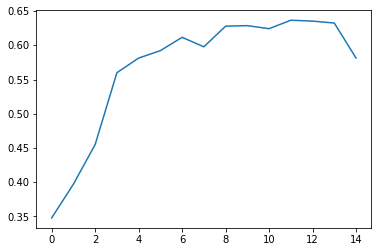

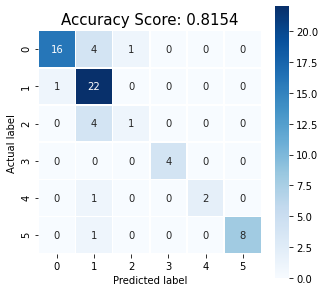

In [59]:
# sem pré processamentos
fit_random_forest(15,Xtrain,ytrain,Xtest,ytest)

(15, 0.819493772351708, 0.8307692307692308)

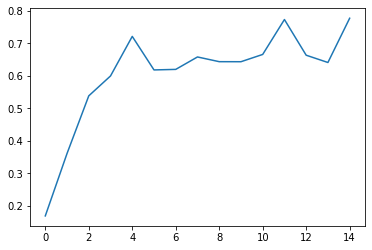

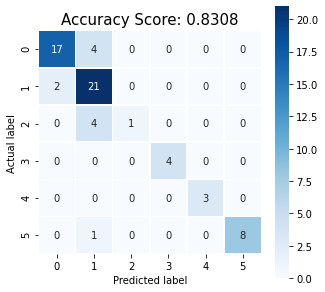

In [60]:
# com oversampling
fit_random_forest(15,Xtrain_over,ytrain_over,Xtest,ytest)

(10, 0.7391897189412147, 0.7692307692307693)

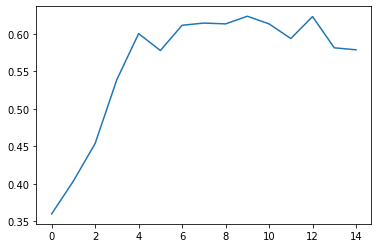

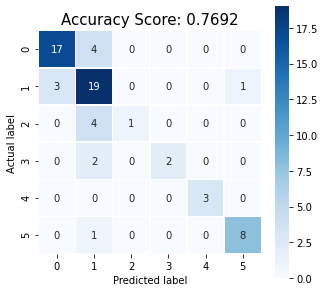

In [61]:
# com scaling
fit_random_forest(15,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(12, 0.7379244380679101, 0.7538461538461538)

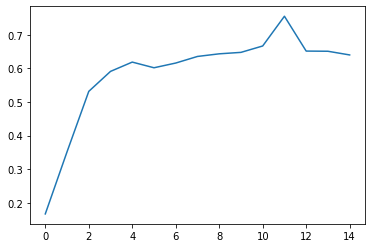

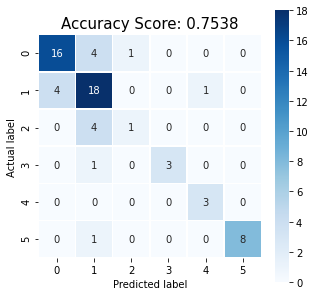

In [62]:
# com oversampling e scaling
fit_random_forest(15,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

In [63]:
# cross validation, evaluation e desempenho do KNN
# por meio da variação do nº de vizinhos
def fit_knn(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(var)
  
  for j in range(0,var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):
      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      neigh = KNeighborsClassifier(n_neighbors = j+1)
      neigh.fit(Xtrain_kfold, ytrain_kfold)
      ypred_kfold = neigh.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
    acc_vec[j] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = acc_vec.argmax() + 1

  # execução KNN com o hiperparâmetro n_neighbors ideal
  neigh = KNeighborsClassifier(n_neighbors = best_var)
  neigh.fit(Xtrain_p, ytrain_p)
  y_predict = neigh.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

(1, 0.5931981488247473, 0.6461538461538462)

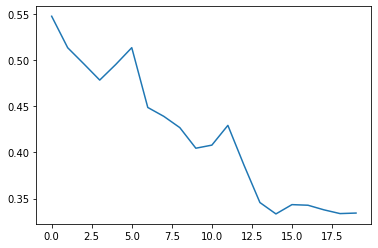

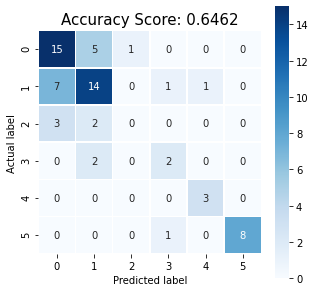

In [64]:
# com scaling
fit_knn(20,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(1, 0.5931981488247473, 0.6461538461538462)

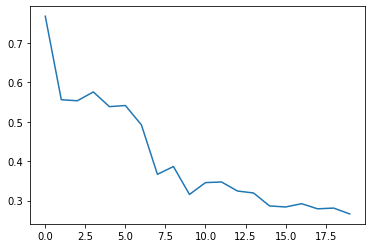

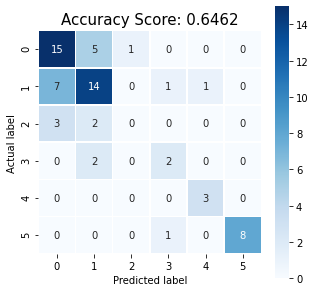

In [65]:
# com oversampling e scaling
fit_knn(20,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

In [67]:
# cross validation, evaluation e desempenho do SVC
# por meio da variação do C
def fit_svc(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(len(var))
  
  for i,j in enumerate(var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):

      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      

      reg = SVC(gamma='auto',kernel='linear',C=j)
      reg.fit(Xtrain_kfold,ytrain_kfold)
      ypred_kfold = reg.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
      
    acc_vec[i] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = var[acc_vec.argmax()]

  # execução SVC com o hiperparâmetro C ideal
  reg = SVC(gamma='auto',kernel='linear',C=best_var)
  reg.fit(Xtrain_p,ytrain_p)
  y_predict = reg.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)
  
  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

In [68]:
vec_reg = [1e-1,1e+0,1e+1,1e+2,1e+3,1e+4,1e+5,1e+6,1e+7]

(10000.0, 0.6293419310369847, 0.676923076923077)

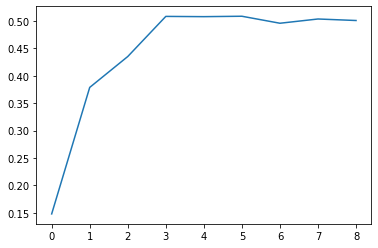

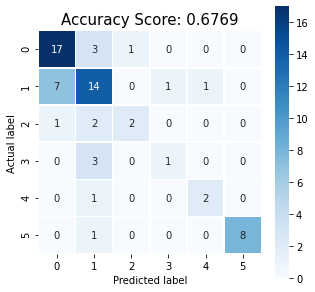

In [69]:
# com scaling
fit_svc(vec_reg,Xtrain_scaled,ytrain,Xtest_scaled,ytest)

(1000.0, 0.5342268112918926, 0.6307692307692307)

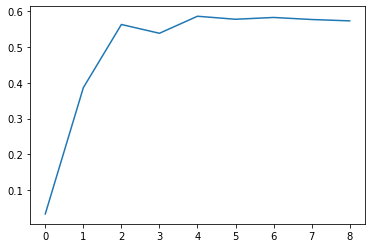

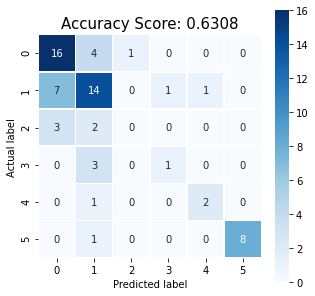

In [70]:
# com oversampling e scaling
fit_svc(vec_reg,Xtrain_over_scaled,ytrain_over_scaled,Xtest_scaled,ytest)

**Gráficos e Visualizações**

Quantidade de amostras total: [70 76 17 13  9 29]


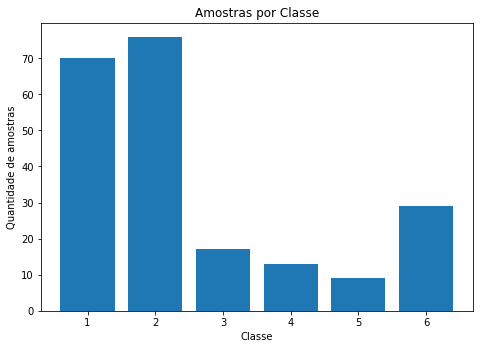

In [ ]:
# gráfico da quantidade de amostras por classe
unique, counts = np.unique(y, return_counts=True)
print("Quantidade de amostras total:",counts)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1,2,3,4,5,6],[70,76,17,13,9,29])
plt.title("Amostras por Classe")
plt.xlabel("Classe")
plt.ylabel("Quantidade de amostras")
plt.show()

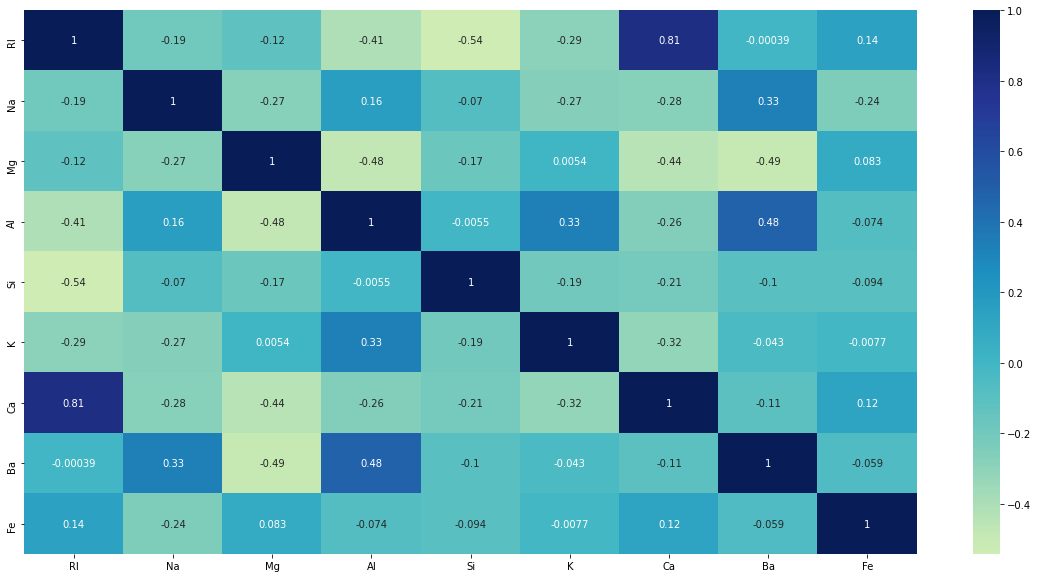

In [22]:
# correlation matrix
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True, ax=ax,cmap="YlGnBu", center = 0)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


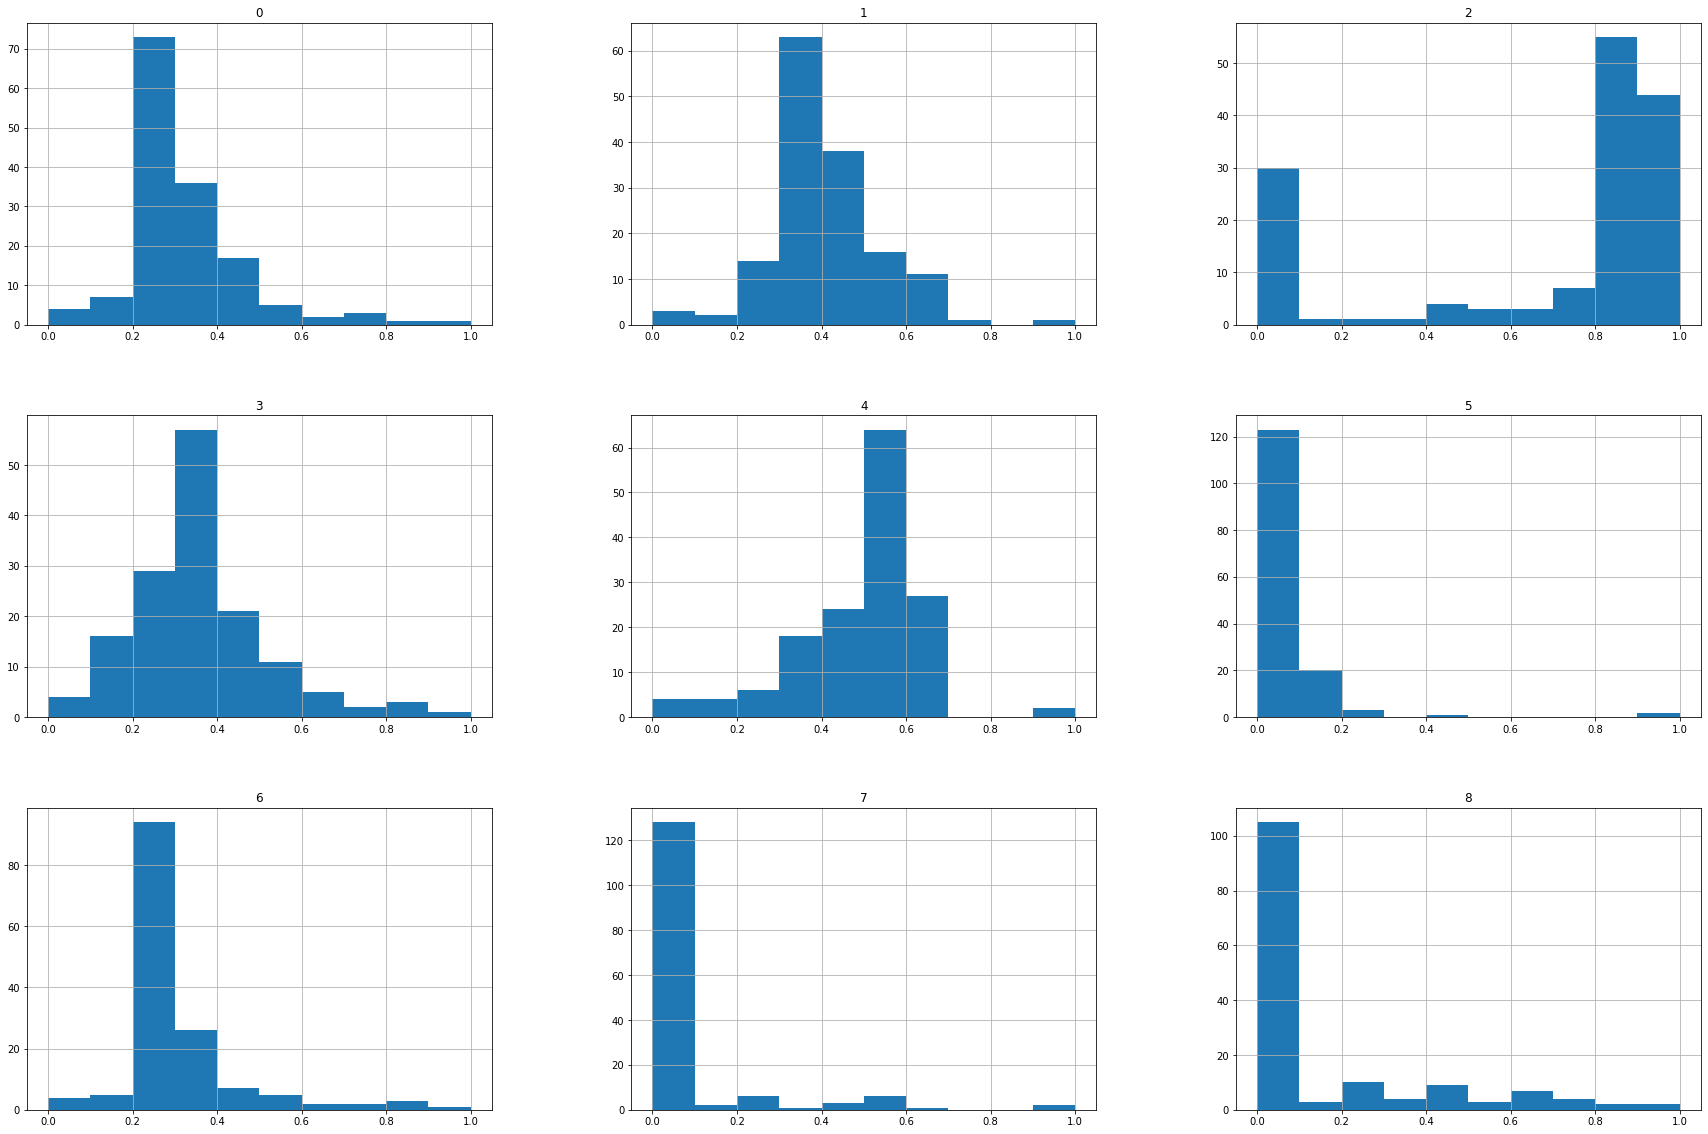

In [24]:
# histograma com scaling
Xtrainpd = pd.DataFrame(Xtrain_scaled)
fig, ax = plt.subplots(figsize=(30,20)) 
Xtrainpd.hist(ax = ax)
pass

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

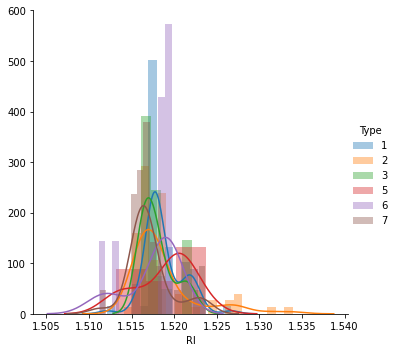

In [25]:
sns.FacetGrid(df,hue="Type",height=5).map(sns.distplot,"RI").add_legend();

**Regressão Logística**
descartada por não convergir

In [26]:
def fit_reg(var,Xtrain_p, ytrain_p, Xtest_p,ytest_p):
  n_splits_kfold = 4
  kf = KFold(n_splits = n_splits_kfold)
  acc_vec = np.zeros(len(var))
  
  for i,j in enumerate(var):
    acc = 0
    for train_index, test_index in kf.split(Xtrain_p):

      Xtrain_kfold, Xtest_kfold = Xtrain_p[train_index], Xtrain_p[test_index]
      ytrain_kfold, ytest_kfold = ytrain_p[train_index], ytrain_p[test_index]
      
      reg = LogisticRegression(fit_intercept=True,multi_class='multinomial', C=j,max_iter=500)
      reg.fit(Xtrain_kfold,ytrain_kfold)
      ypred_kfold = reg.predict(Xtest_kfold)
      acc += f1_score(ytest_kfold, ypred_kfold, average='macro')
      
      
    acc_vec[i] = acc/n_splits_kfold
  plt.plot(acc_vec)
  best_var = var[acc_vec.argmax()]

  # método com o hiperparâmetro ideal
  reg = LogisticRegression(fit_intercept=True,multi_class='multinomial', C=best_var,max_iter=500)
  reg.fit(Xtrain_p,ytrain_p)
  y_predict = reg.predict(Xtest_p)
  f1_predict = f1_score(ytest_p, y_predict, average='macro')
  acc_predict = accuracy_score(ytest_p,y_predict)

  cmatrix = sk.confusion_matrix(ytest_p,y_predict)
  plt.figure(figsize=(5,5))
  sns.heatmap(cmatrix_ran, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy_score(ytest_p,y_predict))
  plt.title(all_sample_title, size = 15)

  return(best_var,f1_predict,acc_predict)

fit_reg(vec_reg,Xtrain_scaled,ytrain,Xtest_scaled,ytest)